# Accumulated Local Effects (ALE) plots

In [1]:
#!pip install scikit-learn==1.0.1
#!pip install --user alibi

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# you may need to install alibi
from alibi.explainers import ALE, plot_ale

In [2]:
cal_housing = fetch_california_housing()

In [3]:
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
X = cal_housing.data
y = cal_housing.target

print(f'Features: {cal_housing.feature_names}')
print(f'Label: {cal_housing.target_names}')

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Label: ['MedHouseVal']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
lr_reg = LinearRegression()

lr_reg.fit(X_train, y_train)

LinearRegression()

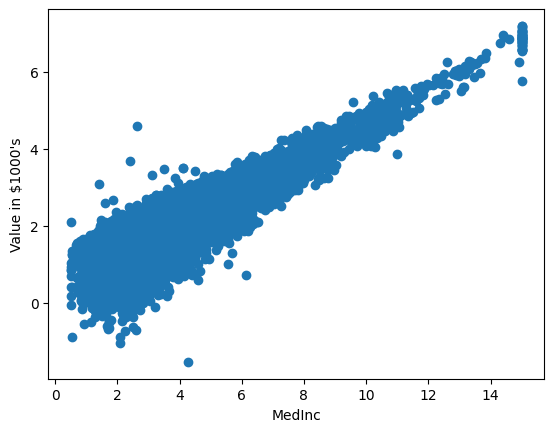

In [7]:
FEATURE = 'MedInc'
feature_names = cal_housing.feature_names
index = feature_names.index(FEATURE)

fig, ax = plt.subplots()
ax.scatter(X_train[:, index], lr_reg.predict(X_train));

ax.set_xlabel(FEATURE);
ax.set_ylabel('Value in $1000\'s');

In [8]:
lr_reg.coef_[index]

0.4419099068100328

In [9]:
lr_ale = ALE(lr_reg.predict,
             feature_names=feature_names,
             target_names=['Median House Value'])

In [10]:
lr_exp = lr_ale.explain(X_train)

In [11]:
len(lr_exp.ale_values[index])

386

array([[<AxesSubplot: xlabel='MedInc', ylabel='ALE'>]], dtype=object)

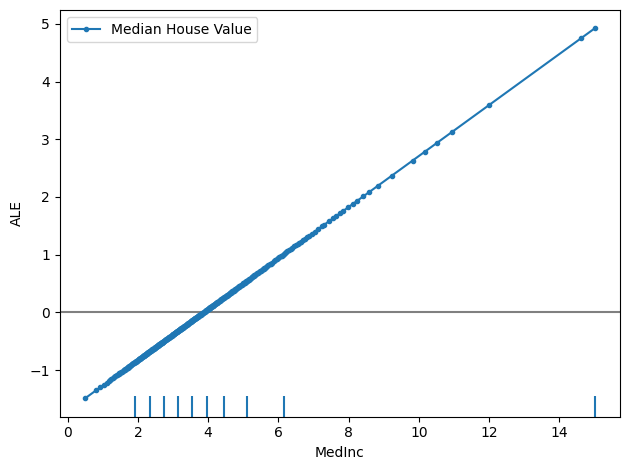

In [12]:
plot_ale(lr_exp, features=[FEATURE])

When the median income (`MedInc`) is 12, the ALE value is about 3.

In [13]:
lr_exp.ale_values[index][-3]

array([3.58603466])

Take the examples in `X_train` that a have `MedInc` close to 12 and compute the average of the model predictions on this subset. 

In [14]:
lower_index = np.where(lr_exp.feature_values[index] < 12)[0][-1]
upper_index = np.where(lr_exp.feature_values[index] > 12)[0][0]

print(f'lower_index: {lower_index}')
print(f'upper_index: {upper_index}')

lower_index: 383
upper_index: 384


In [15]:
lr_exp.feature_values[index][358]

6.696148571428562

In [16]:
lr_exp.feature_values[index][359]

6.759874285714286

In [17]:
subset = X_train[(X_train[:, index] > lr_exp.feature_values[index][lower_index])
                 & (X_train[:, index] < lr_exp.feature_values[index][upper_index])]
print(f'shape of subset: {subset.shape}')

shape of subset: (43, 8)


In [18]:
subset_pred = lr_reg.predict(subset).mean()
subset_pred

5.998642730974021

In [19]:
mean_pred = lr_reg.predict(X_train).mean()
mean_pred

2.063641872577678

In [20]:
subset_pred - mean_pred

3.935000858396343

### Now for a non-linear model

In [21]:
rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, y_train)

RandomForestRegressor()

array([[<AxesSubplot: xlabel='MedInc', ylabel='ALE'>]], dtype=object)

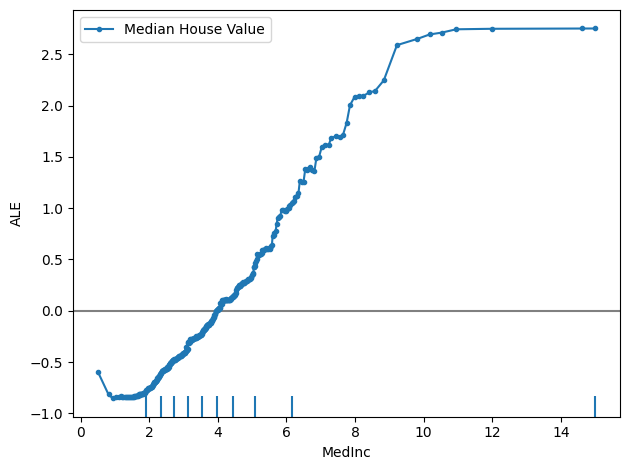

In [22]:
FEATURE = 'MedInc'
feature_names = cal_housing.feature_names
index = feature_names.index(FEATURE)

rf_ale = ALE(rf_reg.predict,
             feature_names=feature_names,
             target_names=['Median House Value'])
rf_exp = rf_ale.explain(X_train)
plot_ale(rf_exp, features=[FEATURE])

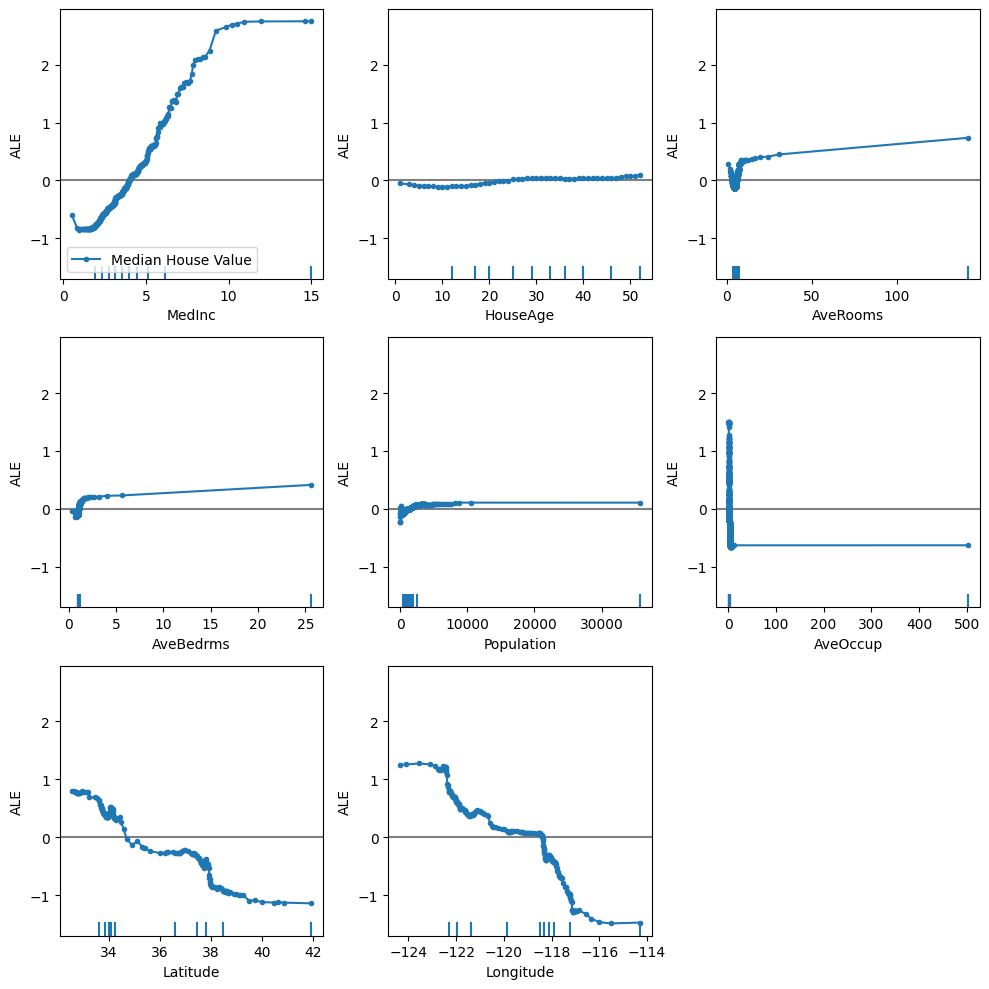

In [23]:
plot_ale(rf_exp, fig_kw={'figwidth':10, 'figheight': 10})
plt.show()

List the most imporant features for the Random Forest model.

In [24]:
indices = rf_reg.feature_importances_.argsort()[::-1]
for ind in indices:
    print(feature_names[ind])

MedInc
AveOccup
Latitude
Longitude
HouseAge
AveRooms
Population
AveBedrms


### Comparing features across diffrent models

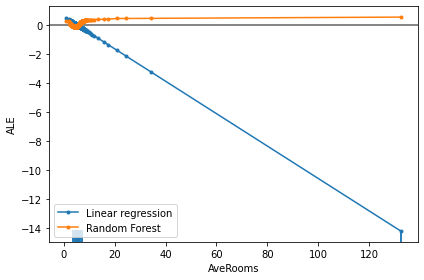

In [46]:
fig, ax = plt.subplots()
plot_ale(lr_exp, features=['AveRooms'], ax=ax, line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, features=['AveRooms'], ax=ax, line_kw={'label': 'Random Forest'});

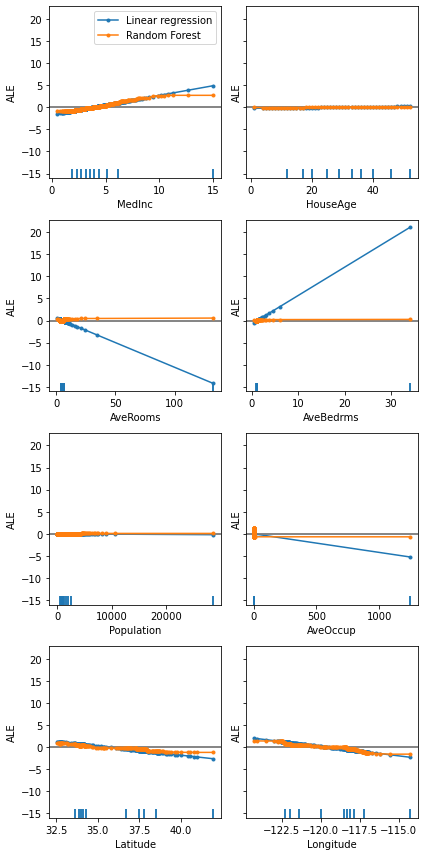

In [47]:
fig, ax = plt.subplots(4, 2, sharey='all');

plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':6, 'figheight': 12},
         line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random Forest'});

For some they have similar importance. For others, like Average number of bedrooms or average number of room, they are quite different.

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License